# Visualizing Key Biodiversity Areas in the Continental United States

### A Study Project in Collaboration with NatureServe

* **Christy Sandberg**, *data processing and analysis*
* **Eric Nutt**, *scientific communication*
* **Lana Kurakina**, *GIS and spatial data processing support*
* **Elsa Culler**, *mentor*
* **Pat Comer**, *project partner*

## Biodiversity Unprotected is Biodiversity Lost

This is a critical time for conservation, as many ecosystems across the globe are at risk of being lost due to deforestation, construction, large-scale agriculture, human encroachment, climate change etc. There are multiple agencies and organizations working on both a regional and global level to fast-track conservation efforts.

Scientists bring together collected data from a variety of biological and ecological sources and execute a workflow to define areas that successfully meet the required criteria. These data sources can include:

* species populations, 
* vegetative land cover, 
* nesting sites, 
* seasonal feeding patterns 
* or even the location of historic cultural heritage sites.  

In 2021, U.S. President Joe Biden launched the *‘America the Beautiful’* initiative, with the stated goal of conserving at least 30 percent of U.S. lands and waters by 2030. Globally, the International Union for Conservation of Nature (IUCN) has been working since 2004 on a standard for identifying **Key Biodiversity Areas (KBAs)**, which are defined as areas essential to supporting the persistence of global biodiversity at either a species or ecosystem level. Once **KBAs** are established and the information is shared with stakeholders, that area becomes prioritized for conservation planning.

<table>
    <tr>
        <td>
            <img src='https://s3.amazonaws.com/hoc-dev/E9vS_CFXEAEo8Oo.jpeg'>
            <div style='width: 200px; text-align: center;'>America the Beautiful Iniative </div>
        </td>
        <td>
            <img src='https://capitalscoalition.org/wp-content/uploads/2016/11/Screen-Shot-2016-11-04-at-14.36.27.png'>
            <div style='width: 200px; text-align: center;'>IUCN: Key Biodiversity Areas </div>
        </td>
    </tr>
</table>

## Understanding the Problem

The IUCN is aware their KBA standard will evolve over time, and actively seeks input from users who work with the current criteria and may have suggestions for improvement. Our project sponsor **Pat Comer** is a member of the IUCN **Commission on Ecosystem Management**, and is interested in whether the current thresholds adequately allow for **KBAs** to be defined for all ecosystems.

Currently, the standard is set so that a **KBA** can be identified at a site that comprises **10%** of the global extent of an ecosystem defined as **‘Vulnerable’** by the IUCN Red List of Ecosystems (RLE), or at **5%** when the ecosystem is at the higher risk **‘Critical’** or **‘Endangered’** level.

## Area of Interest

Our team examined nine different terrestrial ecosystems across the continental United States. They are presented below as a shapefile generated from open source GIS software and clearly distrubute a diverse set of spatial characteristics. The individual ecosystems were extracted from a national raster dataset (Landfire, 2016).

In [2]:
# Import libraries
import os
from glob import glob

import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.plot import plotting_extent
import earthpy as et

# Set working directory
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

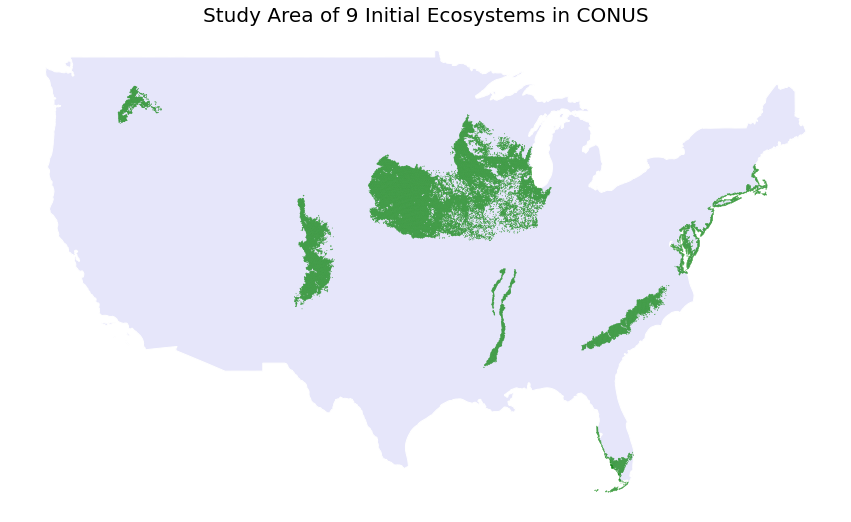

In [2]:
# Study Area
study_area = gpd.read_file(os.path.join('spatial-vector-lidar',
                                        'usa',
                                        'usa-boundary-dissolved.shp'))

# Set paths to hexes
path_hex = os.path.join('data','natureserve', 'shp_hex')
ecosystem_hex_paths = sorted(glob(os.path.join(path_hex, '*.shp')))

# Plot the Study Area
fig, ax = plt.subplots(figsize=(15, 9))
ax.set_title('Study Area of 9 Initial Ecosystems in CONUS',
             fontsize=20)

study_area.plot(ax=ax, 
                edgecolor="white", 
                color = "lavender",
                linewidth=1,
                zorder=1)

for afile in ecosystem_hex_paths:
    shp = gpd.read_file(afile)
    shp_4326 = shp.to_crs(epsg=4326)
    shp_4326.plot(ax=ax, color='green', zorder=2)

ax.axis('off')

## Working Towards a Solution

Our project creates a toolkit for spatial analysis to help identify KBAs, across the continental United States. Our goal is to utilize computer coding to produce an automatic workflow that can analyze spatial distributions of any terrestrial ecosystem type and determine where it could meet the KBA threshold criteria. Our toolkit will also help determine if these **current thresholds may be set too high, especially for ecosystems with linear or fragmented spatial characteristics**. In these instances, it can be difficult to locate independent areas large enough to qualify for conservation using the current standard, or that are in close enough proximity to other areas to allow them to be managed together as a single conservation unit. 

We aim to determine whether lower thresholds would be more successful in identifying KBAs for ecosystems with such spatial characteristics. If so, that may be a useful revision for the IUCN to make to their standard, as ultimately the goal is to identify KBAs for all threatened ecosystems.

Results of the analysis are shared with key stakeholders and decision makers, enabling them to efficiently direct limited resources towards solutions with the lowest cost and greatest chance for long term ecological success.

## Visualizing Key Biodiversity Areas

Our methodology for identifying and visualizing KBAs relies primarily on a software called Marxan. Simply put, Marxan analyzes the number of raster cells in each hexagon overlaying the ecosystem, and from that analysis determines what areas of the ecosystem are closer together, and which areas are further apart. The more bunched up the ecosystem in a given contiguous area, the more likely it is to meet the KBA criteria. To visualize this process, we used Marxan to generate a heat map of each ecosystem. Red cells on the map depict areas with little to no ecosystem present. As we move along the gradient, from yellow to green, more and more of that particular ecosystem is present within a single hex cell. Green on the map indicates areas where we are likely to meet the given KBA threshold. 

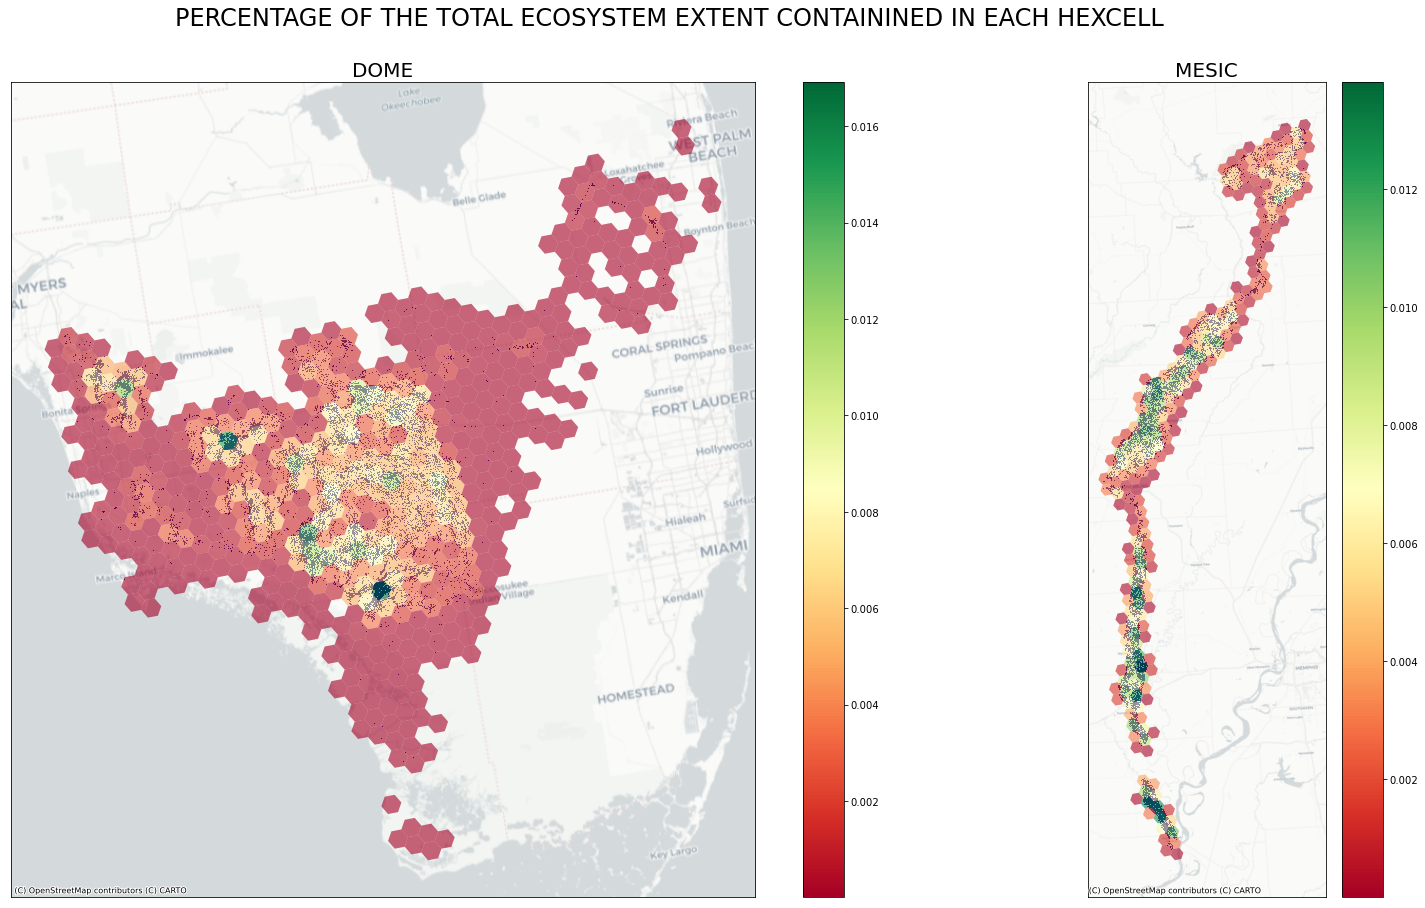

In [17]:
ecolist = ('dome', 'mesic')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25,15), gridspec_kw={'width_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.5)
fig.suptitle(t=("Percentage of the Total Ecosystem Extent "
             "Containined in Each Hexcell\n").upper(), fontsize=24, y=0.95)

for eco, ax in zip(ecolist, axs.ravel()):
    # open the shp file
    shp_data_path = os.path.join("natureserve", "source_data", 
                                 eco + '_w_best_&_hex_as_%_of_total.shp')
    shp_layer = gpd.read_file(shp_data_path)

    # open the tif file
    tif_data_path = os.path.join("natureserve", "source_data", 
                                 eco + '_espg_5070.tif')
    tif_layer = rxr.open_rasterio(tif_data_path, masked=True).squeeze()
    
    # define raster extent for plotting
    raster_extent = plotting_extent(tif_layer, tif_layer.rio.transform())
    
    shp_layer.plot(column='% of total', 
                   cmap='RdYlGn',
                   ax=ax,
                   alpha=0.60, 
                   legend=True)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title(eco.upper(), fontsize=20)
    ctx.add_basemap(ax=ax, crs=shp_layer.crs, 
                    source=ctx.providers.CartoDB.Positron)
    ax.imshow(tif_layer, cmap='jet', extent=raster_extent,
      interpolation='nearest')

plt.show()

(-1810739.8217100264,
 -1515885.191089952,
 2681195.5020201444,
 2912384.8005802394)

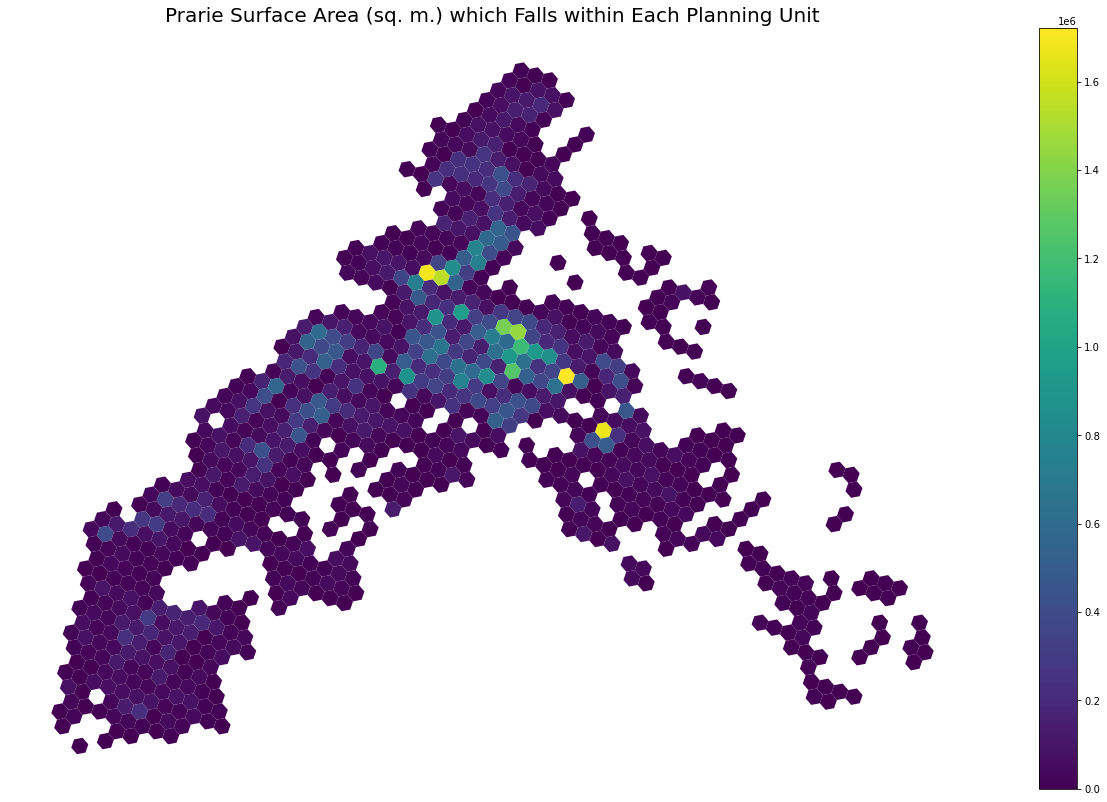

In [4]:
# Visualize results
prarie_marxan = gpd.read_file(os.path.join('natureserve',
                                           'marxan_prep',
                                           'prarie',
                                           'pulayerfeatures.shp'))
prarie_marxan
fig, ax = plt.subplots(figsize=(22, 14))
ax.set_title('Prarie Surface Area (sq. m.) which Falls within \
Each Planning Unit', fontsize=20)
prarie_marxan.plot(column='VALUE_7142', ax=ax, legend=True)
ax.axis('off')

## Steps for the Future

Ultimately, we plan to share this workflow with scientists around the globe, so they can identify and protect their own KBAs to include threatened ecosystems and species. Therefore, we hope to make the current KBA identification process sensitive to a greater variety of ecosystem types, allowing it to be scaled up globally. KBA Identification is one key step in protecting these threatened ecosystems. If these areas are not identified, they are at risk of being destroyed, along with the biodiversity they support. 

While our heat-maps provide a good indication for what areas of each ecosystem meets the threshold to be considered a KBA, we would like to enhance our workflow to generate a clear and precise answer for which areas should be protected. We are currently waiting for an update on the functionality of the Marxan software to allow us to perform the final analytical step that will produce the discrete statistical data we are looking for.

## Find Out More

To find out more about our project, please visit our project repository on GitHub by following the link below.
https://github.com/csandberg303/kba-threshold-sensitivity-analysis
Here you can find more information about the project, our python code workflows used to generate our findings, and other project resources.

### Resources
1. LANDFIRE, 2016, **Existing Vegetation Type Layer**, LANDFIRE 2.0.0, U.S. Department of the Interior, Geological Survey, and U.S. Department of Agriculture. Accessed 28 October 2021 at http://www.landfire/viewer.
2. **Nested Hexagon Framework (NHF)**, developed by Mike Houts at the University of Kansas, provided by Pat Comer.

# Export Notebook as HTML File

In [5]:
! jupyter nbconvert kba-project-blog-post.ipynb --no-input --to html

[NbConvertApp] WARNING | pattern 'kba-project-blog-post.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--stdout
    Write notebook outpu